In [4]:
include("./modules/OpticalCavity.jl")
include("./modules/Thermodynamics.jl")
include("./modules/Phaseonium.jl")
include("./modules/BosonicOperators.jl")
include("./modules/Measurements.jl")

using LinearAlgebra
using SparseArrays
using Expokit
using ProgressBars
using Plots
using LaTeXStrings
using BenchmarkTools


using .OpticalCavity
using .Thermodynamics
using .Phaseonium
using .BosonicOperators
using .Measurements

include("./src/RoutineFunctions.jl")

":)"

## Function to benchmark

In [30]:
function bosonic_operators(α, ϕ)
    
    C = BosonicOperators.C(Ω*Δt, NDIMS)
    Cp = BosonicOperators.Cp(Ω*Δt, NDIMS)
    S = BosonicOperators.S(Ω*Δt, NDIMS)
    Sd = BosonicOperators.Sd(Ω*Δt, NDIMS)
    
    return [C, Cp, S, Sd]
end


function adiabaticevolve_dot(ρ, cavities, Δt, t, allocated_op, π_parts, stop1, stop2)
    U, idd = allocated_op
    n₁, n₂, π_a, π_ad = π_parts
    
    Δt² = Δt^2  

    c1, c2 = cavities
    α0 = c1.α

    a1 = c1.acceleration
    a2 = c2.acceleration
    
    # Move the cavity walls
    if !stop1
        c1.length += 0.5 * c1.acceleration * Δt²
        # Constrain the cavity movement blocking the walls
        c1.length = clamp(c1.length, c1.l_min, c1.l_max)
    end
    if !stop2
        c2.length += 0.5 * c2.acceleration * Δt²
        # Constrain the cavity movement blocking the walls
        c2.length = clamp(c2.length, c2.l_min, c2.l_max)
    end
    
    
    # Update energies
    ω₁ = α0 / c1.length
    ω₂ = α0 / c2.length
    h1 = 0.5 * ω₁ .* n₁
    h2 = 0.5 * ω₂ .* n₂
    h = kron(h1, h2)
    
    # Evolve the System
    U .= padm(-im .* h)
    ρ = U * ρ * U'
    
    # Update pressure and acceleration
    n₁ = (2 * n₁ + idd) - (π_a .* exp(-2*im*ω₁*t)) - (π_ad .* exp(2*im*ω₁*t))
    n₂ = (2 * n₂ + idd) - (π_a .* exp(-2*im*ω₂*t)) - (π_ad .* exp(2*im*ω₂*t))
    p1 = Measurements.pressure(ρ, n₁, idd, α0, c1.length, c1.surface; s=1)
    p2 = Measurements.pressure(ρ, n₂, idd, α0, c2.length, c2.surface; s=2)
    
    a1 = (p1 * c1.surface - c1.external_force) / c1.mass
    a2 = (p2 * c2.surface - c2.external_force) / c2.mass
    
    
    if norm(a1) <= 0.05 || norm(a2) <= 0.05
        error("One cavity is almost still")
    end
    if c1.acceleration * a1 < 0 || c2.acceleration * a2 < 0 
        error("One cavity changed direction!")
    end
    c1.acceleration = a1
    c2.acceleration = a2

    if c1.acceleration == 0 || c2.acceleration == 0
        error("One cavity stopped")
    end

    return ρ, c1, c2
end

function adiabaticevolve_2(ρ, cavities, Δt, t, allocated_op, π_parts, stop1, stop2)
    U, idd = allocated_op
    n, π_a, π_ad = π_parts
    
    Δt² = Δt^2  

    c1, c2 = cavities
    α0 = c1.α

    a1 = c1.acceleration
    a2 = c2.acceleration
    
    # Move the cavity walls
    if !stop1
        c1.length += 0.5 * c1.acceleration * Δt²
        # Constrain the cavity movement blocking the walls
        c1.length = clamp(c1.length, c1.l_min, c1.l_max)
    end
    if !stop2
        c2.length += 0.5 * c2.acceleration * Δt²
        # Constrain the cavity movement blocking the walls
        c2.length = clamp(c2.length, c2.l_min, c2.l_max)
    end
    
    
    # Update energies
    ω₁ = α0 / c1.length
    ω₂ = α0 / c2.length
    h1 = 0.5 * ω₁ .* n
    h2 = 0.5 * ω₂ .* n
    h = kron(h1, h2)
    
    # Evolve the System
    U .= padm(-im .* h)
    ρ = U * ρ * U'
    
    # Update pressure and acceleration
    π₁ = (2 * n + idd)  - (π_a * exp(-2*im*ω₁*t)) - (π_ad * exp(2*im*ω₁*t))
    π₂ = (2 * n + idd)  - (π_a * exp(-2*im*ω₂*t)) - (π_ad * exp(2*im*ω₂*t))
    p1 = Measurements.pressure(ρ, π₁, idd, α0, c1.length, c1.surface; s=1)
    p2 = Measurements.pressure(ρ, π₂, idd, α0, c2.length, c2.surface; s=2)
    
    a1 = (p1 * c1.surface - c1.external_force) / c1.mass
    a2 = (p2 * c2.surface - c2.external_force) / c2.mass
    
    
    if norm(a1) <= 0.05 || norm(a2) <= 0.05
        error("One cavity is almost still")
    end
    if c1.acceleration * a1 < 0 || c2.acceleration * a2 < 0 
        error("One cavity changed direction!")
    end
    c1.acceleration = a1
    c2.acceleration = a2

    if c1.acceleration == 0 || c2.acceleration == 0
        error("One cavity stopped")
    end

    return ρ, c1, c2
end

adiabaticevolve_2 (generic function with 1 method)

In [6]:
const NDIMS = 15
const Ω = 1.0
const Δt = 1e-2

const T_initial = 1.0
const T_heating = 1.2
const T_cooling = 0.7

# Create a Cavity
const α0 = π
const min_l = 1.0
const max_l = 1.1
const expanding_force = 0.5
cavity1 = Cavity(1.0, 1.0, min_l, max_l, α0, expanding_force)
cavity2 = Cavity(1.0, 1.0, min_l, max_l, α0, expanding_force)
ω = α0 / min_l

ρt = thermalstate(NDIMS, ω, T_initial)
println(
    "Initial Temperature of the Cavity:
    $(Measurements.temperature(ρt, ω))")
# Joint system
ρ_tot = kron(ρt, ρt)

# Jump Operators
a = BosonicOperators.destroy(NDIMS)
ad = BosonicOperators.create(NDIMS)

# Create Phaseonium atoms
# For thermal (diagonal) phaseoniums, the Master Equation is the same as having ϕ=π/2
# Heating
ϕ_h = π/3
α_h = Phaseonium.alpha_from_temperature(T_heating, ϕ_h, ω) 

const ga_h, gb_h = Phaseonium.dissipationrates(α_h, ϕ_h)
println(
    "Apparent Temperature carried by Hot Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω, ga_h, gb_h))")

bosonic_h = bosonic_operators(α_h, ϕ_h)

# Cooling
ϕ_c = π/4
α_c = Phaseonium.alpha_from_temperature(T_cooling, ϕ_c, ω) 

const ga_c, gb_c = Phaseonium.dissipationrates(α_c, ϕ_c)
println(
    "Apparent Temperature carried by Cold Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω, ga_c, gb_c))")

bosonic_c = bosonic_operators(α_c, ϕ_c)
;

Initial Temperature of the Cavity:
    1.0
Apparent Temperature carried by Hot Phaseonium atoms: 
    1.2
Apparent Temperature carried by Cold Phaseonium atoms: 
    0.7


7.05738796825963e-5
4.980672493453579e-9
1.142357410494068


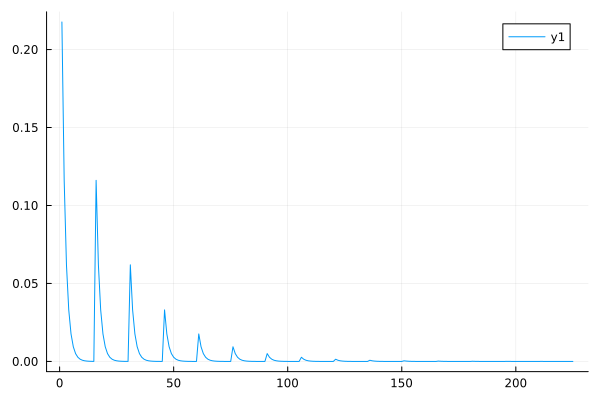

In [7]:
# How many dimensions do we need?
ndims = NDIMS
tstate = thermalstate(ndims, ω, 5)
txtstate = kron(tstate, tstate)
println(tstate[end])
println(txtstate[end])
# Jump Operators
a = BosonicOperators.destroy(ndims)
ad = BosonicOperators.create(ndims)
n_photons = tr(tstate * ad * a)
println(n_photons)
g1 = heatmap(1:ndims^2, 1:ndims^2, txtstate)
g2 = plot(1:ndims^2, diag(txtstate))

### Check State

In [8]:
# Check number of photons and cutoff
println(tr(ρt*ad*a))
println(ρt[end])

0.04516570536368411
7.577848096386027e-20


In [9]:
ndims = NDIMS

rho1 = thermalstate(ndims, ω, 1.5)
println("N1 = $(tr(rho1*ad*a))")
rho2 = thermalstate(ndims, ω, 1)
println("N2 = $(tr(rho2*ad*a))")

identity_matrix = spdiagm(ones(ndims))
n = ad * a
π_a = a * a
π_ad = ad * ad

πOp = (2 * n + identity_matrix)  - (π_a * exp(-2*im*ω)) - (π_ad * exp(2*im*ω))
p1 = Measurements.pressure(rho1, πOp, identity_matrix, α0, min_l, 1.0)
println("P1 = $p1")
p2 = Measurements.pressure(rho2, πOp, identity_matrix, α0, min_l, 1.0)
println("P2 = $p2")

N1 = 0.1404390355221817
N2 = 0.04516570536368411
P1 = 2.0119985690686195
P2 = 1.7126885749596477


### Test 1

In [35]:
ρ_f = convert(SparseMatrixCSC{ComplexF64, Int64}, ρ_tot)
stop1 = false
stop2 = false
t = 0
# Operators are defined on one subspace
dims = Int(sqrt(size(ρ_f)[1]))
identity_matrix = spdiagm(ones(dims))
# Reduce precision
a = convert(SparseMatrixCSC{Float32, Int64}, a)
ad = convert(SparseMatrixCSC{Float32, Int64}, ad)
# Pressure Operator
# Decomposed in three parts (constant and rotating)
n1 = ad * a
n2 = copy(π_const1) 
π_a = a * a
π_ad = ad * ad
π_parts = (n1, n2, π_a, π_ad) 

# Preallocate variables with reduce precision
π₁, π₂ = spzeros(ComplexF32, size(n)...), spzeros(ComplexF32, size(n)...)
h = spzeros(Float32, size(ρ_f)...)
U = spzeros(ComplexF32, size(ρ_f)...)
# ρ = convert(SparseMatrixCSC{ComplexF32, Int64}, ρ)  # Convert real sparse matrix to complex sparse
alloc = (U, identity_matrix);

In [36]:
@benchmark adiabaticevolve_dot($ρ_f, $(cavity1, cavity2), $Δt, $t, $alloc, $π_parts, $stop1, $stop2)

BenchmarkTools.Trial: 444 samples with 1 evaluation per sample.
 Range (min … max):   8.499 ms … 44.765 ms  ┊ GC (min … max):  0.00% … 0.00%
 Time  (median):     10.486 ms              ┊ GC (median):    14.04%
 Time  (mean ± σ):   11.262 ms ±  3.634 ms  ┊ GC (mean ± σ):  15.18% ± 6.76%

    ▃█▂▁▅                                                      
  ▄▇█████▆▄▄▅▅▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▆
  8.5 ms       Histogram: log(frequency) by time      41.3 ms <

 Memory estimate: 24.11 MiB, allocs estimate: 279.

### Test 2

In [33]:
ρ_f = convert(SparseMatrixCSC{ComplexF64, Int64}, ρ_tot)
# Operators are defined on one subspace
dims = Int(sqrt(size(ρ_f)[1]))
identity_matrix = spdiagm(ones(dims))
# Reduce precision
a = convert(SparseMatrixCSC{Float32, Int64}, a)
ad = convert(SparseMatrixCSC{Float32, Int64}, ad)
# Pressure Operator
# Decomposed in three parts (constant and rotating)
n = ad * a
π_a = a * a
π_ad = ad * ad
π_parts = (n, π_a, π_ad) 

# Preallocate variables with reduce precision
π₁, π₂ = spzeros(ComplexF32, size(n)...), spzeros(ComplexF32, size(n)...)
h = spzeros(Float32, size(ρ_f)...)
U = spzeros(ComplexF32, size(ρ_f)...)
# ρ = convert(SparseMatrixCSC{ComplexF32, Int64}, ρ)  # Convert real sparse matrix to complex sparse
alloc = (U, identity_matrix);

In [34]:
@benchmark adiabaticevolve_2($ρ_f, $(cavity1, cavity2), $Δt, $t, $alloc, $π_parts, $stop1, $stop2)

BenchmarkTools.Trial: 428 samples with 1 evaluation per sample.
 Range (min … max):   8.478 ms … 41.298 ms  ┊ GC (min … max):  0.00% … 0.00%
 Time  (median):     11.379 ms              ┊ GC (median):    13.06%
 Time  (mean ± σ):   11.677 ms ±  2.845 ms  ┊ GC (mean ± σ):  14.60% ± 6.89%

       ▄▂  ▂▃▂ ▄   ███▆▃▁ ▁   ▅  ▅                             
  ▄▁▄▄▄██▄▇██████▄▄████████▇▇▇█▆▇█▄▄▄▄▁▁▁▁▁▄▁▁▁▁▁▆▁▄▁▁▁▁▁▁▁▁▄ ▇
  8.48 ms      Histogram: log(frequency) by time      17.5 ms <

 Memory estimate: 23.36 MiB, allocs estimate: 280.